<font size="6">  <strong> Modelling of low carbon technologies and materials:</strong> <br>
<font size="5"> The case of electric vehicle batteries
   

<font size="3">*By Joris Baars, Newcastle University, UK, 2021* <br> 


In [1]:
#Import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging as log
import sys, os
import copy
import pyomo.environ as pyo
import sys
import openpyxl
%matplotlib inline

In [2]:
#Local modules
#path to ODYM:
sys.path.insert(0, os.path.join(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\ODYM')) 
import ODYM_Classes as msc
import ODYM_Functions as msf

#Path to battery cost and LCA:
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model')
import battery_emissions as bat_lca
import battery_cost as bat_cost

#Logfile
log_verbosity = eval("log.INFO")
log_filename  = 'log_file.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)

#Path to all parameter files:
datapath = r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\Case study'


## Model setup: Initialization, classifications and data
The following block establishes the indextable and parameter dictionary based on the ODYM data model structure (config file, model classification file and ODYM database structure).

### Read config and classification file

In [3]:

# Read config file and sheet
config_file   = openpyxl.load_workbook(datapath+'\model_config.xlsx', data_only=True)
script_config = {'Model Setting': config_file['Cover']['D4'].value}
config_sheet  = config_file['Setting_'+script_config['Model Setting']]
project_name  = config_sheet['D2'].value
ScriptConfig  = msf.ParseModelControl(config_sheet,script_config)

#Parse configfile 
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(config_sheet,script_config, Mylog ) 

#Load classification file and establish classification dictionary:
Classfile            = openpyxl.load_workbook(datapath+'\model_classification.xlsx', data_only=True)
Classsheet           = Classfile['MAIN_Table']
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = copy.deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = \
            [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.info('ITEM SELECT ERROR for aspect ' + IT_Aspects[m] + ' were found in datafile.</br>')
        break

INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


### Establish index table


In [4]:
Mylog.info('Define index table dataframe')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

IndexTable

INFO (2963534744.py <<module>>): Define index table dataframe


,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Regions,Battery production locations in Europe,Region,<ODYM_Classes.Classification object at 0x00000...,r,8
Process,All foreground processes,Process,<ODYM_Classes.Classification object at 0x00000...,p,129
Bat_process,Battery manufacturing process,Process,<ODYM_Classes.Classification object at 0x00000...,b,27
Goods,All foreground goods,Material,<ODYM_Classes.Classification object at 0x00000...,g,115
Internal_goods,Goods flowing inside factory,Material,<ODYM_Classes.Classification object at 0x00000...,i,15
Waste,Waste materials,Material,<ODYM_Classes.Classification object at 0x00000...,w,12
Energy,Electricity and heat,Energy,<ODYM_Classes.Classification object at 0x00000...,n,2
Elements,Chemical elements,Material,<ODYM_Classes.Classification object at 0x00000...,e,11
Emissions,ReCiPe Midpoint (H) V1.13 no LT,Satellite,<ODYM_Classes.Classification object at 0x00000...,h,17


### Load model parameters

In [6]:
Mylog.info('Reading data files into ParameterDict')
                                                 
ParameterDict = {}
mo_start = 0 # set mo for re-reading a certain parameter
for mo in range(mo_start,len(PL_Names)):
    # print (PL_Names[mo] )
    try:
        ParPath = os.path.join(datapath+"\Data", PL_Names[mo] + '_' + PL_Version[mo])
        Mylog.info('Reading parameter ' + PL_Names[mo])
        # Do not change order of parameters handed over to function!
        MetaData, Values = msf.ReadParameterXLSX(ParPath, PL_Names[mo], PL_IndexStructure[mo], PL_IndexMatch[mo],
                                             PL_IndexLayer[mo], MasterClassification, IndexTable,
                                             IndexTable_ClassificationNames, ScriptConfig, Mylog, False)
        ParameterDict[PL_Names[mo]] = msc.Parameter(Name=MetaData['Dataset_Name'], ID=MetaData['Dataset_ID'],
                                                    UUID=MetaData['Dataset_UUID'], P_Res=None, MetaData=MetaData,
                                                    Indices=PL_IndexStructure[mo], Values=Values, Uncert=None,
                                                    Unit=MetaData['Dataset_Unit'])
           
    except ValueError:
        PL_Names[mo] 
        Mylog.info(f'{PL_Names[mo]} includes strings')
        MetaData, Values = msf.ReadParameterXLSX(ParPath, PL_Names[mo], PL_IndexStructure[mo], PL_IndexMatch[mo],
                                             PL_IndexLayer[mo], MasterClassification, IndexTable,
                                             IndexTable_ClassificationNames, ScriptConfig, Mylog, False, 
                                                 string_data = True) # Add string_data is True to include string dtype in np array.
        ParameterDict[PL_Names[mo]] = msc.Parameter(Name=MetaData['Dataset_Name'], ID=MetaData['Dataset_ID'],
                                                    UUID=MetaData['Dataset_UUID'], P_Res=None, MetaData=MetaData,
                                                    Indices=PL_IndexStructure[mo], Values=Values, Uncert=None,
                                                    Unit=MetaData['Dataset_Unit'])
        
    
    
#     Mylog.info('Current parameter file UUID: ' + MetaData['Dataset_UUID'])
    Mylog.info('_')
Mylog.info('Reading of parameters finished.')
print ('ParameterDict loaded', ParameterDict)



INFO (2568819162.py <<module>>): Reading data files into ParameterDict
INFO (2568819162.py <<module>>): Reading parameter 3_PR_factor_price
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 93 values was read from file for parameter 3_PR_factor_price.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 24.0 of 24 values for parameter 3_PR_factor_price were assigned.
INFO (2568819162.py <<module>>): _
INFO (2568819162.py <<module>>): Reading parameter 3_PR_material_price_unit
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 17 values was read from file for parameter 3_PR_material_price_unit.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 17.0 of 7360 values for parameter 3_PR_material_price_unit were assigned.
INFO (2568819162.py <<module>>): _
INFO (2568819162.py <<module>>): Reading parameter 3_PR_material_price_mass
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 55 values was read from file for parameter 3_PR_material_price_mass.
INFO (ODYM_Functions.py <ReadParamet

ParameterDict loaded {'3_PR_factor_price': <ODYM_Classes.Parameter object at 0x000001F5E4F310A0>, '3_PR_material_price_unit': <ODYM_Classes.Parameter object at 0x000001F5E4F31040>, '3_PR_material_price_mass': <ODYM_Classes.Parameter object at 0x000001F5E4FB7FD0>, '3_PR_mineral_price': <ODYM_Classes.Parameter object at 0x000001F5E53D0DC0>, '3_PR_regional_energy_price': <ODYM_Classes.Parameter object at 0x000001F5E54D11C0>, '3_MC_materials_pack_design': <ODYM_Classes.Parameter object at 0x000001F5E55EE070>, '3_MC_element_goods': <ODYM_Classes.Parameter object at 0x000001F5E4F7BEE0>, '3_PAR_battery_parameters': <ODYM_Classes.Parameter object at 0x000001F5E4FCCAC0>, '4_PY_battery_manufacturing': <ODYM_Classes.Parameter object at 0x000001F5E561AE80>, '4_UPI_foreground_base': <ODYM_Classes.Parameter object at 0x000001F5DFBBD190>, '4_PE_modules_base': <ODYM_Classes.Parameter object at 0x000001F5B277D4F0>, '4_PE_sensitivity_materials': <ODYM_Classes.Parameter object at 0x000001F585F78040>, '4_

In [7]:
#Index shortcuts:
r = IndexTable.loc['Regions', 'Classification'].Items
p = IndexTable.loc['Process', 'Classification'].Items
g = IndexTable.loc['Goods', 'Classification'].Items
D = IndexTable.loc['Battery_designs', 'Classification'].Items
P = IndexTable.loc['Technical_parameters', 'Classification'].Items
bp = IndexTable.loc['Bat_process', 'Classification'].Items
h = IndexTable.loc['Emissions', 'Classification'].Items
f = IndexTable.loc['Factors', 'Classification'].Items
e =IndexTable.loc['Elements', 'Classification'].Items
p_electricity = [x for x in p if 'market group for electricity battery production, medium voltage' in x]
p_gas = [x for x in p if 'market group for heat, district or industrial, natural gas' in x]

# Parameter shortcuts:
# dataframe of A default matrix:
df_A_base = pd.DataFrame(data=ParameterDict['4_UPI_foreground_base'].Values, index=g, columns = p)
# np array of default gate-to-gate emission modules
H_base = ParameterDict['4_PE_modules_base'].Values 
# np array of battery design parameters
bat_design_param = ParameterDict['3_PAR_battery_parameters'].Values
# np array of battery design material content
mc_battery_designs = ParameterDict['3_MC_materials_pack_design'].Values


#material content and battery design dictionary shortcut:
mc_battery_design_dct = pd.DataFrame(data=mc_battery_designs.T, index = g, columns = D).to_dict()
bat_design_param_dct = pd.DataFrame(data=bat_design_param.T, index = P, columns =D).to_dict()


## Calculate parameters

#### Nested foreground matrix ($\mathbf{A}^{'}$)

In [8]:
from tqdm import tqdm
process_formula = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\process_formulas.xlsx"
process_formula =pd.read_excel(process_formula, sheet_name = 'activity_functions_cut_off', index_col=[1,2]).T.to_dict()
project_param_formulas =r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\bw_default_project_parameters.xlsx"
project_param_formulas = pd.read_excel(project_param_formulas, index_col=0).fillna(0).T.to_dict()


IndexTable

#Empty np array of size total design*py scenarios * electricity_scenario* goods * processes
A_matrix_nested = np.zeros((len(D), IndexTable.loc['Yield_scenario', 'IndexSize'], len(g), len(p)))

#Dictionary of all system parameters:
param_dict_all = {}
A_base = df_A_base.copy(deep=True)

for x in tqdm(D):#pack designs
    for s in range(IndexTable.loc['Yield_scenario', 'IndexSize']):
        process_parameters = {param: value for param, value in zip (IndexTable.loc['Process_parameter', 'Classification'].Items, 
                                                                    ParameterDict['4_PY_battery_manufacturing'].Values[:,s])}
        process_parameters.update({param: value for param, value in zip (IndexTable.loc['Process_parameter', 'Classification'].Items, 
                                                                    ParameterDict['4_PAR_energy_consumption'].Values[:,1]) if value > 0})
        param_dict_all[x] = bat_lca.parameter_dictionary (mc_battery_design_dct[x], process_parameters, bat_design_param_dct[x], project_param_formulas)
        A_matrix = bat_lca.calculate_modular_A(A_base,param_dict_all[x], process_formula, project_param_formulas)
        
        
        A_matrix_nested[x,s,:] = A_matrix



100%|██████████| 20736/20736 [03:12<00:00, 107.59it/s]


## Calculate emissions for all pack designs:

In [1171]:
country = 'European average'

electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))
        
        
impact_cat = 2 #GWP100
H_nested_square = np.zeros([len(D), IndexTable.loc['Yield_scenario', 'IndexSize'], len(process_selection)])



for d in range(len(D)):
    for py in range(2): #process yield scenario:
        # for gr in graphite:
    #append specific graphite process on location 0
        fu = A_matrix_nested[d,py,g.index('battery pack'),p.index('module and pack assembly')] #pack weight as function unit
        # Inverse the A' matrix:
        A_inv = np.linalg.pinv(A_matrix_nested[d,py,:, process_selection].T) 
        # Establish final product demand vector for 1 battery based on pack weight
        y = np.zeros(len(g))
        y[g.index('battery pack')] = fu
        s = A_inv.dot(y)
        H_nested_square[d, py,  :] = s* H_base[impact_cat, process_selection]
            

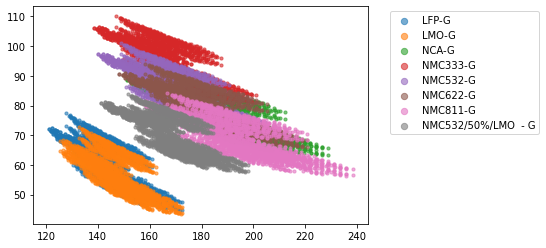

In [1172]:
colour= []
colour_dict = {'LFP-G':'tab:blue', 'LMO-G':'tab:orange', 'NCA-G':'tab:green','NMC333-G':'tab:red', 'NMC532-G':'tab:purple', 'NMC622-G':'tab:brown', 'NMC811-G':'tab:pink',
            'NMC532/50%/LMO  - G':'tab:gray'}

cathode_by_design = {x:bat_design_param_dct[x]['electrode_pair'] for x in D}
all_cathode_chemistries = set(cathode_by_design.values())
emissions_all = {x:H_nested_square[x,0,  :].sum()/bat_design_param_dct[x]['pack_energy_kWh'] for x in D}
density = {x:bat_design_param_dct[x]['pack_usable_energy_kWh']/bat_design_param_dct[x]['battery_system_weight']*1000 for x in D}

for design in cathode_by_design.keys():
    colour_code = colour_dict[cathode_by_design[design]]
    colour.append(colour_code)

energy_con= {}

dict_y_values = {}
fig, ax = plt.subplots()

for cathode, c in colour_dict.items():
    dict_y_values [cathode] =[emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    # ax.boxplot(y)
    y = [emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    x = [density[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    ax.scatter (x,y, c=c, s=10, label = cathode, alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',markerscale =2 )

In [139]:
## CALCULATE EMISSIONS by VARYING PRODUCTION LOCATION

H_energy_location = np.zeros((len(r), len(D), len(process_selection)))

for idx_country, country in enumerate(r):

    electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
    gas_choice = f'market group for heat, district or industrial, natural gas, {country}'


    process_selection = []

    for x in p:
        if x == electricity_choice:
            process_selection.append(p.index(x))
        elif x == gas_choice:
            process_selection.append(p.index(x))
        elif x in p_electricity or x in p_gas:
            continue
        else:
            process_selection.append(p.index(x))
            
    impact_cat = 2 #GWP100
    

    for d in range(len(D)):

        fu = A_matrix_nested[d,0,g.index('battery pack'),p.index('module and pack assembly')] #pack weight as function unit
        # Inverse the A' matrix:
        A_inv = np.linalg.pinv(A_matrix_nested[d,0,:,process_selection].T) 
        # Establish final product demand vector for 1 battery based on pack weight
        y = np.zeros(len(g))
        y[g.index('battery pack')] = fu
        s = A_inv.dot(y)
        H_energy_location[idx_country,d ,] = s* H_base[impact_cat, process_selection]
                



In [140]:
## CALCULATE EMISSIONS by VARYING ELECTRICITY CONSUMPTIONS
uncertainty_range = [1, 3, 5, 7, 9]

A_energy_uncertainty = np.zeros((len(uncertainty_range), len(D), len(g), len(p)))

df_energy_consumption = pd.DataFrame(ParameterDict['4_PAR_energy_consumption'].Values, IndexTable.set_index('IndexLetter').loc['o', 'Classification'].Items, IndexTable.set_index('IndexLetter').loc['G', 'Classification'].Items)
df_energy_consumption = df_energy_consumption[df_energy_consumption>0].dropna()
df_energy_consumption = df_energy_consumption.iloc[range(0,15)]['average'].drop('electricity_consumption_formation')

 
for x in tqdm(D):#pack designs
    for x2 in uncertainty_range:
        
        process_parameters = {param: value for param, value in zip (IndexTable.loc['Process_parameter', 'Classification'].Items, 
                                                                    ParameterDict['4_PY_battery_manufacturing'].Values[:,0])}
        process_parameters.update({param: value for param, value in zip (IndexTable.loc['Process_parameter', 'Classification'].Items, 
                                                                    ParameterDict['4_PAR_energy_consumption'].Values[:,1]) if value > 0})
        process_parameters.update((df_energy_consumption*x2).to_dict())
        param_dict_all[x] = bat_lca.parameter_dictionary (mc_battery_design_dct[x], process_parameters, bat_design_param_dct[x], project_param_formulas)
        A_matrix = bat_lca.calculate_modular_A(A_base,param_dict_all[x], process_formula, project_param_formulas)
        
        
        A_energy_uncertainty[uncertainty_range.index(x2),x,] = A_matrix


100%|██████████| 20736/20736 [07:04<00:00, 48.84it/s]


In [141]:
gas_consumption = {}
electricity_consumption = {}
energy_consumption_kwh = {}
gas_index = g.index( 'heat, district or industrial, natural gas for battery production')
electricity_index = g.index( 'electricity for battery production, medium voltage')


for i in range(0,5):
    gas_consumption [i] = []
    electricity_consumption [i]=[]
    energy_consumption_kwh [i] = []
    for d in D:
        capacity = param_dict_all[d]['pack_energy_kWh']
        gas = abs(A_energy_uncertainty[i, d,gas_index, [p.index(x) for x in bp]]).sum()/3.6/capacity
        electricity = abs(A_energy_uncertainty[i, d,electricity_index, [p.index(x) for x in bp]]).sum()/capacity
        gas_consumption[i].append(abs(A_energy_uncertainty[i, d,gas_index, [p.index(x) for x in bp]]).sum()/3.6/capacity)
        electricity_consumption[i].append(abs(A_energy_uncertainty[i, d,electricity_index, [p.index(x) for x in bp]]).sum()/capacity)
        energy_consumption_kwh[i].append(  gas+electricity)

In [143]:
country = 'European average'

electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))
        
        
impact_cat = 2 #GWP100
H_energy_uncertainty = np.zeros([len(uncertainty_range), len(D), len(process_selection)])


for d in range(len(D)):
    for x2 in uncertainty_range: #energy uncertinaty range
        # for gr in graphite:
    #append specific graphite process on location 0
        fu = A_matrix_nested[d,0,g.index('battery pack'),p.index('module and pack assembly')] #pack weight as function unit
        # Inverse the A' matrix:
        A_inv = np.linalg.pinv(A_energy_uncertainty[uncertainty_range.index(x2),d,:,process_selection].T) 
        # Establish final product demand vector for 1 battery based on pack weight
        y = np.zeros(len(g))
        y[g.index('battery pack')] = fu
        s = A_inv.dot(y)
        H_energy_uncertainty[uncertainty_range.index(x2),d ,] = s* H_base[impact_cat, process_selection]
            

In [1]:
emissions_all = {}
t = {}
q = {}
for cathode, c in colour_dict.items():
    t[cathode] = []
    q[cathode]=[]
    for en in range(0,5):

        
        emissions_all = [H_nested_square[en,x,  :].sum()/bat_design_param_dct[x]['pack_usable_energy_kWh'] for x in D]
        y = [emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
        
        energy_kwh = [
            abs(
                A_energy_uncertainty[en, x, [el_idx]].T[battery_production_index].sum()
                + A_energy_uncertainty[en, x, [gas_idx]].T[battery_production_index].sum()/3.6
            )
            / bat_design_param_dct[x]["pack_energy_kWh"]
            for x in D
        ]
        x = [energy_kwh[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
        t[cathode].append (np.mean(y ))
        q[cathode].append(np.mean(x))


    

In [ ]:

el_idx = g.index(IndexTable.loc["Energy", "Classification"].Items[0])
gas_idx = g.index(IndexTable.loc["Energy", "Classification"].Items[1])

dict_y_values= {}
for en_sc in range(0,5):
    
    energy_kwh = [
        abs(
            A_energy_uncertainty[en_sc, x, [el_idx]].T[battery_production_index].sum()
            + A_energy_uncertainty[en_sc, x, [gas_idx]].T[battery_production_index].sum()/3.6
        )
        / bat_design_param_dct[x]["pack_energy_kWh"]
        for x in D
    ]
    emissions_all = {x:H_nested_square[en_sc,x,  :].sum()/bat_design_param_dct[x]['pack_usable_energy_kWh'] for x in D}
    cathode_by_design = {x:bat_design_param_dct[x]['electrode_pair'] for x in D}
    all_cathode_chemistries = set(cathode_by_design.values())

    colour= []
    colour_dict = {'LFP-G':'tab:blue', 'LMO-G':'tab:orange', 'NCA-G':'tab:green','NMC333-G':'tab:red', 'NMC532-G':'tab:purple', 'NMC622-G':'tab:brown', 'NMC811-G':'tab:pink',
                'NMC532/50%/LMO  - G':'tab:gray'}

    for design in cathode_by_design.keys():
        colour_code = colour_dict[cathode_by_design[design]]
        colour.append(colour_code)

    energy_con= {}

        
    # fig, ax = plt.subplots()

    for cathode, c in colour_dict.items():
        dict_y_values [en_sc, cathode] =[emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
        # ax.boxplot(y)
        # y = [emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
        # x = [energy_kwh[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
        # ax.scatter (x,y, c=c, s=10, label = cathode, alpha=0.6)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',markerscale =2 )


In [ ]:

fig, ax = plt.subplots(2, 4, sharey=True)

for i, cathode in enumerate(colour_dict.keys()):
    if i >3:
        i -=4
        temp_dict = {}
        for en_sc in range(0,5):
            temp_dict [en_sc] = dict_y_values[en_sc, cathode]
            
        ax[1, i].violinplot(temp_dict.values())
        ax[1,i].set_title(cathode)
        # ax[1,i].set_xticks(temp_dict.keys())
        
    else:
        for en_sc in range(0,5):

            temp_dict [en_sc] = dict_y_values[en_sc, cathode]
            
        ax[0, i].violinplot(temp_dict.values())
        ax[0,i].set_title(cathode)
        
fig.tight_layout()


In [ ]:
#Segments:
segment_A = D
scenario_py = 1

emissions_all = {x:H_nested_square[0,x,  :].sum()/bat_design_param_dct[x]['pack_energy_kWh'] for x in segment_A}

cathode_by_design = {x:bat_design_param_dct[x]['electrode_pair'] for x in segment_A}
all_cathode_chemistries = set(cathode_by_design.values())
specific_energy ={}
battery_weight = {}
for x in segment_A:
    specific_energy[x]=bat_design_param_dct[x]['pack_energy_kWh']/mc_battery_design_dct[x]['battery pack']*1000
    battery_weight[x] =mc_battery_design_dct[x]['battery pack']
    

colour= []
colour_dict = {'LFP-G':'tab:blue', 'LMO-G':'tab:orange', 'NCA-G':'tab:green','NMC333-G':'tab:red', 'NMC532-G':'tab:purple', 'NMC622-G':'tab:brown', 'NMC811-G':'tab:pink',
               'NMC532/50%/LMO  - G':'tab:gray'}

for design in cathode_by_design.keys():
    colour_code = colour_dict[cathode_by_design[design]]
    colour.append(colour_code)

    
fig, ax = plt.subplots()

dict_y_values = {}

for cathode, c in colour_dict.items():
    y = [emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    x = [specific_energy[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    dict_y_values [cathode] = y
    ax.scatter (x,y, c=c, s=10, label = cathode, alpha=0.6)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim([55,110])

plt.ylabel('kg CO$_2$-eq./kWh')
plt.xlabel(r'Pack specific energy useable (Wh kg$^{-1}$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',markerscale =2 )


In [ ]:
  
fig, ax = plt.subplots()

dict_y_values = {}
y_chemistry = []
colour_dict = {'LMO-G':'tab:orange', 'LFP-G':'tab:blue','NMC811-G':'tab:pink','NMC532/50%/LMO  - G':'tab:gray','NCA-G':'tab:green',
                'NMC622-G':'tab:brown','NMC532-G':'tab:purple','NMC333-G':'tab:red',
               }

for cathode, c in colour_dict.items():
    y = [emissions_all[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    x = [specific_energy[i] for i in cathode_by_design.keys() if cathode_by_design[i] == cathode]
    dict_y_values [cathode] = y
  
colour_dict = {' ':' ', 'LMO':'tab:orange', 'LFP':'tab:blue','NMC811':'tab:pink','NMC532/50%/LMO':'tab:gray','NCA':'tab:green',   'NMC622':'tab:brown',
               'NMC532':'tab:purple','NMC333':'tab:red',}

ax.violinplot (dict_y_values.values(), vert=False, widths=0.7, showmedians =True)
ax.set_yticklabels(colour_dict.keys())


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim([55,110])

In [ ]:
## Energy consumption and battery location:

uncertainty_range = [1, 3, 5, 7, 9]

H_energy_location_energy_scenario = np.zeros((len(r), len(uncertainty_range), len(D)))

for idx_country, country in enumerate(r):

    electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
    gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

    process_selection = []

    for x in p:
        if x == electricity_choice:
            process_selection.append(p.index(x))
        elif x == gas_choice:
            process_selection.append(p.index(x))
        elif x in p_electricity or x in p_gas:
            continue
        else:
            process_selection.append(p.index(x))
            
    impact_cat = 2 #GWP100
    
    for x2  in range(len(uncertainty_range)):

        for d in range(len(D)):

            fu = A_matrix_nested[d,0,g.index('battery pack'),p.index('module and pack assembly')] #pack weight as function unit
            # Inverse the A' matrix:
            A_inv = np.linalg.pinv(A_energy_uncertainty[x2,d,:,process_selection].T) 
            # Establish final product demand vector for 1 battery based on pack weight
            y = np.zeros(len(g))
            y[g.index('battery pack')] = fu
            s = A_inv.dot(y)
            H_energy_location_energy_scenario[idx_country, x2,d] = (s* H_base[impact_cat, process_selection]).sum()
            
                



## Sensitivity analysis carbon footprint

## Battery minerals sensitivity 



In [ ]:
country = 'European average'
electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
gas_choice = f'market group for heat, district or industrial, natural gas, {country}'
df_SA_materials = pd.DataFrame(ParameterDict['4_PE_sensitivity_materials'].Values, columns=p, index=IndexTable.loc['Sensitivity_analysis', 'Classification'].Items)
df_SA_materials = df_SA_materials.loc[:, (df_SA_materials != 0).any(axis=0)].drop('used')


H_base_SA = copy.deepcopy(H_base[impact_cat, :])

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))
          
impact_cat = 2 #GWP100
   

SA_materials = np.zeros((len(df_SA_materials.columns), 2, len(D)))  #all process columns * 2 scenarios (low/high) * all designs
for d in D:
    for scenario_i, scenario in enumerate(['low', 'high']):
        for process_i, process in enumerate(df_SA_materials.columns):
            fu = A_matrix_nested[d,py,g.index('battery pack'),p.index('module and pack assembly')] #pack weight as function unit
            # Inverse the A' matrix:
            A_inv = np.linalg.pinv(A_matrix_nested[d,0,:, process_selection].T) 
            # Establish final product demand vector for 1 battery based on pack weight
            y = np.zeros(len(g))
            y[g.index('battery pack')] = fu
            s = A_inv.dot(y)
            H_base_SA[ p.index(process)] = df_SA_materials.loc[scenario, process]
            SA_materials[process_i, scenario_i, d] = (s* H_base_SA[ process_selection]).sum()
            H_base_SA[ p.index(process)] = H_base[impact_cat, p.index(process)] #restore old value
        
    

In [ ]:


design_synth = range(0, len(D), 2)
gwp_syn_low = [SA_materials[2,0,x]/ bat_design_param_dct[x]["pack_energy_kWh"] for x in design_synth]                
gwp_syn_high = [SA_materials[2,1,x]/ bat_design_param_dct[x]["pack_energy_kWh"] for x in design_synth]                

In [ ]:
cathodes = ['LFP-G', 'LMO-G', 'NCA-G', 'NMC333-G', 'NMC532-G', 'NMC622-G', 'NMC811-G', 'NMC532/50%/LMO  - G']
scenarios = ["low","low std","used", "high", "high std"]

df_SA_carbon = pd.DataFrame(
    index=[np.repeat(cathodes,len(scenarios)), scenarios * len(cathodes)],
    columns=[
        'production location',
        'energy consumption',
        'anode active material (natural graphite) import',
       'anode active material (SiO) import',
       'anode active material (synthetic graphite) import',
       'Cobalt sulfate production', 'market for aluminium, wrought alloy',
       'market for cobalt hydroxide', 'market for copper, cathode',
       'market for lithium carbonate', 'market for manganese sulfate',
       'market for nickel sulfate'],
)

def mean_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design].sum() / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.mean(return_value)

def std_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design].sum() / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.std(return_value)

for cathode in cathodes:
    base =  mean_all(cathode, H_energy_location[r.index("European average")])
    base_std = std_all(cathode, H_energy_location[r.index("European average")])


    df_SA_carbon.loc[cathode, "high"]["production location"] =mean_all(cathode, H_energy_location[r.index("PL")])
    df_SA_carbon.loc[cathode, "high std"]["production location"] = std_all(cathode, H_energy_location[r.index("PL")])-base_std
    df_SA_carbon.loc[cathode, "low"]["production location"] =  mean_all(cathode, H_energy_location[r.index("SE")])
    df_SA_carbon.loc[cathode, "low std"]["production location"] = std_all(cathode, H_energy_location[r.index("SE")])-base_std
    
    df_SA_carbon.loc[cathode, "high"]["energy consumption"] = mean_all(cathode, H_energy_uncertainty[4])
    df_SA_carbon.loc[cathode, "high std"]["energy consumption"] = std_all(cathode, H_energy_uncertainty[4])-base_std
    df_SA_carbon.loc[cathode, "low"]["energy consumption"] = base
    df_SA_carbon.loc[cathode, "low std"]["energy consumption"] = 0
    
    for material_i, material in enumerate(df_SA_materials.columns):
        mean_high = mean_all(cathode, SA_materials[material_i, 1])
        std_high =  std_all(cathode, SA_materials[material_i, 1])
        mean_low= mean_all(cathode, SA_materials[material_i, 0])
        std_low =  std_all(cathode, SA_materials[material_i, 0])
        
        
        
        df_SA_carbon.loc[cathode, "high"][material] =  mean_high
        df_SA_carbon.loc[cathode, "high std"][material] =  std_high-base_std
        df_SA_carbon.loc[cathode, "low"][material] = mean_low
        df_SA_carbon.loc[cathode, "low std"][material] =   std_low-base_std
                
        
        if df_SA_materials.loc['low', material] == 0:
            df_SA_carbon.loc[cathode, "low"][material] =   base
            df_SA_carbon.loc[cathode, "low std"][material] =   0
            
        if df_SA_materials.loc['high', material] == 0:
            df_SA_carbon.loc[cathode, "high"][material] =   base
            df_SA_carbon.loc[cathode, "high std"][material] =   0
        if round(mean_low,5) == round(base, 5):
            df_SA_carbon.loc[cathode, "low std"][material] =   0
            df_SA_carbon.loc[cathode, "low"][material] =   base
        if round(mean_high,5) == round(base, 5):
            df_SA_carbon.loc[cathode, "high std"][material] =   0
            df_SA_carbon.loc[cathode, "high"][material] =   base

    df_SA_carbon.loc[cathode, "used"] = base
df_SA_carbon.fillna(0)

production location  energy consumption  \
LFP-G               low                 58.668723           60.274135   
                    low std             -0.021760            0.000000   
                    used                60.274135           60.274135   
                    high                62.737277           83.380601   
                    high std             0.033614            0.804909   
LMO-G               low                 55.597028           57.196218   
                    low std             -0.017877            0.000000   
                    used                57.196218           57.196218   
                    high                59.649814           80.150024   
                    high std             0.027631            0.661942   
NCA-G               low                 75.834240           77.302318   
                    low std             -0.020687            0.000000   
                    used                77.302318           77.302318   
                    high                79.554751           95.022178   
                    high std             0.031945            0.774598   
NMC333-G            low                 93.621421           95.146728   
                    low std             -0.020183            0.000000   
                    used                95.146728           95.146728   
                    high                97.486966          115.152078   
                    high std             0.031170            0.749649   
NMC532-G            low                 84.539271           86.056777   
                    low std             -0.020313            0.000000   
                    used                86.056777           86.056777   
                    high                88.385046          105.749621   
                    high std             0.031371            0.755935   
NMC622-G            low                 78.224909           79.706447   
                    low std             -0.020099            0.000000   
                    used                79.706447           79.706447   
                    high                81.979532           97.963363   
                    high std             0.031039            0.747827   
NMC811-G            low                 68.660355           70.110345   
                    low std             -0.020409            0.000000   
                    used                70.110345           70.110345   
                    high                72.335027           87.105816   
                    high std             0.031515            0.762449   
NMC532/50%/LMO  - G low                 69.001832           70.521380   
                    low std             -0.017224            0.000000   
                    used                70.521380           70.521380   
                    high                72.852781           90.283222   
                    high std             0.026586            0.600463   

                              anode active material (natural graphite) import  \
LFP-G               low                                             60.274135   
                    low std                                          0.000000   
                    used                                            60.274135   
                    high                                            62.818126   
                    high std                                        -0.325918   
LMO-G               low                                             57.196218   
                    low std                                          0.000000   
                    used                                            57.196218   
                    high                                            60.007762   
                    high std                                         0.115995   
NCA-G               low                                             77.302318   
                    low std                                     

# Battery cost

### Nested physical factor requirement matrix ($\mathbf{F}^{'}_{p}$)

In [9]:
default_cost_parameters = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\default_manufacturing_cost_parameters.xlsx"

pd_default_cost = pd.ExcelFile(default_cost_parameters)
default_cost_lst = [
    pd.read_excel(pd_default_cost, sheet_name="p_values_process", index_col=0).drop(
        "unit", axis=1
    ),
    pd.read_excel(pd_default_cost, sheet_name="baseline_factors", index_col=0).drop(
        "unit", axis=1
    ),
    pd.read_excel(
        pd_default_cost, sheet_name="default_manufacturing_rates", index_col=0
    )
    .iloc[:, 0]
    .to_dict(),
    pd.read_excel(pd_default_cost, sheet_name="volume_ratio_mapping", index_col=0)
    .iloc[:, 0]
    .to_dict(),
    pd.read_excel(pd_default_cost, sheet_name="process_mapping", index_col=0)
    .iloc[:, 0]
    .to_dict(),
]


manufacturing_capacity = 100000

for x in param_dict_all.keys():
    param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity

factors = IndexTable.loc["Factors", "Classification"].Items
battery_production_index = [p.index(i) for i in bp]


F_physical_nested = np.zeros((2, len(D), len(factors), len(p)))
for x in tqdm(D):
     for s in range(IndexTable.loc['Yield_scenario', 'IndexSize']):
        param_dict_all[x].update({param: value for param, value in zip (IndexTable.loc['Process_parameter', 'Classification'].Items, 
                                                                    ParameterDict['4_PY_battery_manufacturing'].Values[:,s])})
        param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity
        F_matrix = bat_cost.factors_battery_production(
            param_dict_all[x], run_multiple=default_cost_lst
        ).reindex(columns=bp).fillna(0) #Fill cathode binder solvent waste handling with 0
        F_physical_nested[s,x, :, battery_production_index] = F_matrix.T


100%|██████████| 20736/20736 [06:04<00:00, 56.86it/s]


### Nested monetary factor requirement ($\mathbf{F}^{'}_{m}$)


In [10]:
#Monetary factor requirement per country:
py_yield= 0

F_monetary_nested = np.zeros((len(r), len(D), 3, len(p) ))
for x in tqdm(D):
    for country in r:
        factor_cost          = ParameterDict['3_PR_factor_price'].Values[:,IndexTable.loc['Regions', 'Classification'].Items.index(country)]
        production_capacity= param_dict_all[x]['battery_manufacturing_capacity']
        #Overhead cost:
        factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (production_capacity).values())
        #Total cost
        F_monetary_nested[r.index(country), x, :,battery_production_index] = F_physical_nested[py_yield, x,:,battery_production_index]*(factor_cost*factor_cost_overhead)/production_capacity


100%|██████████| 20736/20736 [00:07<00:00, 2598.48it/s]


### Nested monetary technology matrix (material cost) ($\mathbf{C}^{'}$)

In [630]:
material_category = pd.read_excel(
    r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\material_type_linkage.xlsx",
    sheet_name="values",
)
default_cost_parameters = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\default_manufacturing_cost_parameters.xlsx"
df_pr_material_mass = pd.Series(ParameterDict["3_PR_material_price_mass"].Values, g)
manuf_rate_base = (
    pd.read_excel(
        default_cost_parameters, sheet_name="default_manufacturing_rates", index_col=0
    )
    .iloc[:, 0]
    .to_dict()
)
p_values = (
    pd.read_excel(default_cost_parameters, sheet_name="p_values_materials", index_col=0)
    .iloc[:, 0]
    .to_dict()
)

df_pr_unit = pd.DataFrame(ParameterDict["3_PR_material_price_unit"].Values, g, P)
df_pr_unit = df_pr_unit[(df_pr_unit != 0).any(axis=1)]


manufacturing_capacity = 100000

for x in param_dict_all.keys():
    param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity

dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2



C_matrix_nested = np.zeros((len(D), len(g), len(p)))
unit_material_to_process_mapping = bat_cost.material_to_process_mapping(
    df_pr_unit.index, df_A_base
)

for x in tqdm(D):
    
    A_matrix_temp = pd.DataFrame(A_matrix_nested[x,py_yield, :, :], columns=p, index=g)
    C_matrix = bat_cost.material_cost_matrix(
        A_matrix_temp,
        df_pr_material_mass,
        dict_pr_unit,
        material_category,
        manuf_rate_base,
        p_values,
        param_dict_all[x],
        bp,  # internal processes
        unit_material_to_process_mapping=unit_material_to_process_mapping,
        overhead_multiplier=None,
    )
    C_matrix_nested[x, :, :] = C_matrix.values

# Multiply all materials by overhead multiplier:1.0516, excluding energy
overhead_multiplier_material = 1.0516

C_matrix_nested[
    :,
    [
        g.index("heat, district or industrial, natural gas for battery production"),
        g.index("electricity for battery production, medium voltage"),
    ],
] * overhead_multiplier_material


# Multiply by P values for scaling::
cathode_am = list(
    material_category.set_index("material category").loc[
        "cathode active material", "material choices"
    ]
)
anode_am = list(
    material_category.set_index("material category").loc[
        "anode active material", "material choices"
    ]
)
# get process rates:
for k, v in param_dict_all.items():
    process_rate = bat_cost.modelled_process_rates(v)

    C_matrix_nested[k, g.index("cell terminal anode"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell terminal anode"])

    C_matrix_nested[k, g.index("cell terminal cathode"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell terminal cathode"])

    C_matrix_nested[k, [g.index(cathode) for cathode in cathode_am], :] *= (
        manuf_rate_base["baseline_positive_active_material"]
        / process_rate["positive_active_material"]
    ) ** (1 - p_values["positive active material"])

    C_matrix_nested[k, [g.index(anode) for anode in anode_am], :] *= (
        manuf_rate_base["baseline_negative_active_material"]
        / process_rate["negative_active_material"]
    ) ** (1 - p_values["negative active material"])

    C_matrix_nested[k, g.index("cell container"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell container"])

    C_matrix_nested[k, g.index("module thermal conductor"), :] * (
        manuf_rate_base["baseline_required_cell"] / process_rate["required_cell"]
    ) ** (1 - p_values["module thermal conductor"])


100%|██████████| 20736/20736 [03:55<00:00, 87.98it/s] 


In [631]:
for region in r:
    electricity_price = ParameterDict['3_PR_regional_energy_price'].Values[0, r.index(region)]   
    gas_price = ParameterDict['3_PR_regional_energy_price'].Values[1, r.index(region)]   
    C_matrix_nested[:, 
                    g.index('electricity for battery production, medium voltage'),
                    p.index(f'market group for electricity battery production, medium voltage, {region}')] = electricity_price
    C_matrix_nested[:, 
                    g.index('heat, district or industrial, natural gas for battery production'),
                    p.index(f'market group for heat, district or industrial, natural gas, {region}')] = gas_price

### Establish value added vector ($\mathbf{b}$)


In [666]:
B_matrix_nested = np.zeros((len(D), len(p)))
B_matrix_nested = np.sum(F_monetary_nested[r.index(country)], 1)
B_matrix_nested[:] += np.sum(C_matrix_nested,1)


In [859]:
A_matrix_nested[0,1,:,process_selection].sum()

-1971.3380075877515

In [668]:
country = 'European average'

electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))
        

b_vector_nested_scaled = np.zeros((len(D), len(process_selection)))

# for country in range(len(r)):
for x in D:
    y = np.zeros(len(g))
    y[g.index('battery pack')] = param_dict_all[x]['battery_pack']
    A_inv = np.linalg.pinv(A_matrix_nested[x,py_yield,:,process_selection].T)
    s = A_inv.dot(y)
    b_vector_nested_scaled[x] = (B_matrix_nested[x, process_selection] * s)

In [ ]:
# pd.DataFrame(b_vector_nested_scaled, D, [p[x] for x in process_selection]).to_csv(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\df_cost_materials_99.csv')


### Sensitivity cost

#### different capacity:


In [ ]:

manufacturing_capacity = [20000, 500000]



factors = IndexTable.loc["Factors", "Classification"].Items
battery_production_index = [p.index(i) for i in bp]


F_physical_nested_capacity = np.zeros((2, len(D), len(factors), len(p)))
for i,cap in enumerate(manufacturing_capacity):
    for x in tqdm(D):
        param_dict_all[x]["battery_manufacturing_capacity"] = cap
        F_matrix = bat_cost.factors_battery_production(
            param_dict_all[x], run_multiple=default_cost_lst
        ).reindex(columns=bp).fillna(0) #Fill cathode binder solvent waste handling with 0
        F_physical_nested_capacity[i,x, :, battery_production_index] = F_matrix.T
manufacturing_capacity = 100000

100%|██████████| 20736/20736 [03:03<00:00, 112.92it/s]


In [ ]:
manufacturing_capacity = [20000, 500000]

#Monetary factor requirement per country:
F_monetary_capacity = np.zeros((2, len(D), len(factors), len(p)))
for x in tqdm(D):
    for i, cap in enumerate(manufacturing_capacity):
        factor_cost          = ParameterDict['3_PR_factor_price'].Values[:,IndexTable.loc['Regions', 'Classification'].Items.index(country)]

        #Overhead cost:
        factor_cost_overhead = list(bat_cost.factor_overhead_multiplier (cap).values())
        #Total cost
        F_monetary_capacity[i, x, :,battery_production_index] = F_physical_nested_capacity[i, x,:,battery_production_index]*(factor_cost*factor_cost_overhead)/cap


100%|██████████| 20736/20736 [00:02<00:00, 9991.19it/s] 


In [ ]:
material_category = pd.read_excel(
    r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\material_type_linkage.xlsx",
    sheet_name="values",
)
default_cost_parameters = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\ME optimisation model\ME_battery_supply_chain\Model\data\default_manufacturing_cost_parameters.xlsx"
df_pr_material_mass = pd.Series(ParameterDict["3_PR_material_price_mass"].Values, g)
manuf_rate_base = (
    pd.read_excel(
        default_cost_parameters, sheet_name="default_manufacturing_rates", index_col=0
    )
    .iloc[:, 0]
    .to_dict()
)
p_values = (
    pd.read_excel(default_cost_parameters, sheet_name="p_values_materials", index_col=0)
    .iloc[:, 0]
    .to_dict()
)

df_pr_unit = pd.DataFrame(ParameterDict["3_PR_material_price_unit"].Values, g, P)
df_pr_unit = df_pr_unit[(df_pr_unit != 0).any(axis=1)]


C_matrix_capacity= np.zeros((2, len(D), len(g), len(p)))


for i, cap in enumerate(manufacturing_capacity):

    for x in param_dict_all.keys():
        param_dict_all[x]["battery_manufacturing_capacity"] = cap

    dict_pr_unit = {}
    for k, v in df_pr_unit.T.to_dict().items():
        dict_pr_unit[k] = {}
        for k2, v2 in v.items():
            if v2 != 0:
                dict_pr_unit[k][k2] = v2



    unit_material_to_process_mapping = bat_cost.material_to_process_mapping(
        df_pr_unit.index, df_A_base
    )

    for x in tqdm(D):
        A_matrix_temp = pd.DataFrame(A_matrix_nested[x, 0, :, :], columns=p, index=g)
        C_matrix = bat_cost.material_cost_matrix(
            A_matrix_temp,
            df_pr_material_mass,
            dict_pr_unit,
            material_category,
            manuf_rate_base,
            p_values,
            param_dict_all[x],
            bp,  # internal processes
            unit_material_to_process_mapping=unit_material_to_process_mapping,
            overhead_multiplier=None,
        )
        C_matrix_capacity[i, x, :, :] = C_matrix.values

    # Multiply all materials by overhead multiplier:1.0516, excluding energy
    overhead_multiplier_material = 1.0516

    C_matrix_capacity[i,
        :,
        [
            g.index("heat, district or industrial, natural gas for battery production"),
            g.index("electricity for battery production, medium voltage"),
        ],
    ] * overhead_multiplier_material


    # Multiply by P values for scaling::
    cathode_am = list(
        material_category.set_index("material category").loc[
            "cathode active material", "material choices"
        ]
    )
    anode_am = list(
        material_category.set_index("material category").loc[
            "anode active material", "material choices"
        ]
    )
    # get process rates:
    for k, v in param_dict_all.items():
        process_rate = bat_cost.modelled_process_rates(v)

        C_matrix_capacity[i,k, g.index("cell terminal anode"), :] *= (
            manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
        ) ** (1 - p_values["cell terminal anode"])

        C_matrix_capacity[i,k, g.index("cell terminal cathode"), :] *= (
            manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
        ) ** (1 - p_values["cell terminal cathode"])

        C_matrix_capacity[i,k, [g.index(cathode) for cathode in cathode_am], :] *= (
            manuf_rate_base["baseline_positive_active_material"]
            / process_rate["positive_active_material"]
        ) ** (1 - p_values["positive active material"])

        C_matrix_capacity[i,k, [g.index(anode) for anode in anode_am], :] *= (
            manuf_rate_base["baseline_negative_active_material"]
            / process_rate["negative_active_material"]
        ) ** (1 - p_values["negative active material"])

        C_matrix_capacity[i,k, g.index("cell container"), :] *= (
            manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
        ) ** (1 - p_values["cell container"])

        C_matrix_capacity[i,k, g.index("module thermal conductor"), :] * (
            manuf_rate_base["baseline_required_cell"] / process_rate["required_cell"]
        ) ** (1 - p_values["module thermal conductor"])


100%|██████████| 20736/20736 [03:43<00:00, 92.73it/s] 


#### Regionalised energy prices:


In [ ]:
for region in r:
    electricity_price = ParameterDict['3_PR_regional_energy_price'].Values[0, r.index(region)]   
    gas_price = ParameterDict['3_PR_regional_energy_price'].Values[1, r.index(region)]   
    C_matrix_capacity[i,:, 
                    g.index('electricity for battery production, medium voltage'),
                    p.index(f'market group for electricity battery production, medium voltage, {region}')] = electricity_price
    C_matrix_capacity[i,:, 
                    g.index('heat, district or industrial, natural gas for battery production'),
                    p.index(f'market group for heat, district or industrial, natural gas, {region}')] = gas_price

In [ ]:
B_matrix_capacity = np.zeros((2, len(D), len(p)))
B_matrix_capacity = np.sum(F_monetary_capacity, 2)
B_matrix_capacity[:] += np.sum(C_matrix_capacity,2)

In [ ]:

b_vector_capacity = np.zeros((2, len(D), len(process_selection)))

for i, cap in enumerate(manufacturing_capacity):
    electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
    gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

    process_selection = []

    for x in p:
        if x == electricity_choice:
            process_selection.append(p.index(x))
        elif x == gas_choice:
            process_selection.append(p.index(x))
        elif x in p_electricity or x in p_gas:
            continue
        else:
            process_selection.append(p.index(x))
            


    # for country in range(len(r)):
    for x in D:
        y = np.zeros(len(g))
        y[g.index('battery pack')] = param_dict_all[x]['battery_pack']
        A_inv = np.linalg.pinv(A_matrix_nested[x,0,:,process_selection].T)
        s = A_inv.dot(y)
        b_vector_capacity[i, x] = (B_matrix_capacity[i,x, process_selection] * s)

In [ ]:
## REGIONALISED COST

b_vector_regional= np.zeros((len(r), len(D), len(process_selection)))

for country_i, country in enumerate(r):
    electricity_choice = f'market group for electricity battery production, medium voltage, {country}' 
    gas_choice = f'market group for heat, district or industrial, natural gas, {country}'

    process_selection = []

    for x in p:
        if x == electricity_choice:
            process_selection.append(p.index(x))
        elif x == gas_choice:
            process_selection.append(p.index(x))
        elif x in p_electricity or x in p_gas:
            continue
        else:
            process_selection.append(p.index(x))
            


    # for country in range(len(r)):
    for x in D:
        y = np.zeros(len(g))
        y[g.index('battery pack')] = param_dict_all[x]['battery_pack']
        A_inv = np.linalg.pinv(A_matrix_nested[x,0,:,process_selection].T)
        s = A_inv.dot(y)
        b_vector_regional[country_i, x] = (B_matrix_nested[r.index(country),x, process_selection] * s)

In [2]:
#CALCULATE SA MINERAL PRICES
process_elements = np.einsum('pdg, eg->dep', A_matrix_nested[:,0,:, [p.index(i) for i in bp]], ParameterDict['3_MC_element_goods'].Values)
process_elements_price = np.sum(np.abs(np.einsum('dep,es->sdep', process_elements,ParameterDict['3_PR_mineral_price'].Values )),3)

b_vector_sum = np.sum(b_vector_nested_scaled, 1)

mineral_prices_sa = np.zeros((3, len(e), len(D)))

for i in range(3):
    print (i)
    for element in range(len(e)):
        difference = process_elements_price[1,:, element] - process_elements_price[i,:, element]
        mineral_prices_sa[i, element] = b_vector_sum-difference



In [ ]:
cathodes = ['LFP-G', 'LMO-G', 'NCA-G', 'NMC333-G', 'NMC532-G', 'NMC622-G', 'NMC811-G', 'NMC532/50%/LMO  - G']
scenarios = ["low","low std","used", "high", "high std"]

df_SA_cost = pd.DataFrame(
    index=[np.repeat(cathodes,len(scenarios)), scenarios * len(cathodes)],
    columns=[
        'production location',
        'production capacity',
        'Li', 'Al', 'Si', 'P', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'C' 
      ],
)


def mean_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design].sum() / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.mean(return_value)

def std_all(cathode, values, design_range=None):
    if design_range is None:
        design_range = D
    return_value = [
        values[design].sum() / bat_design_param_dct[design]["pack_energy_kWh"]
        for design in design_range
        if bat_design_param_dct[design]["electrode_pair"] == cathode
    ]
    return np.std(return_value)

for cathode in cathodes:
    base =  mean_all(cathode, mineral_prices_sa[1, 1])
    base_std = std_all(cathode, mineral_prices_sa[1, 1])
    


    df_SA_cost.loc[cathode, "high"]["production location"] = mean_all(cathode, b_vector_regional[r.index('NO')])
    df_SA_cost.loc[cathode, "high std"]["production location"] = std_all(cathode, b_vector_regional[r.index('NO')])-base_std
    df_SA_cost.loc[cathode, "low"]["production location"] =  mean_all(cathode, b_vector_regional[r.index('HU')])
    df_SA_cost.loc[cathode, "low std"]["production location"] = std_all(cathode, b_vector_regional[r.index('HU')])-base_std
    
    df_SA_cost.loc[cathode, "high"]["production capacity"] = mean_all(cathode, b_vector_capacity[0])
    df_SA_cost.loc[cathode, "high std"]["production capacity"] = std_all(cathode, b_vector_capacity[0])-base_std
    df_SA_cost.loc[cathode, "low"]["production capacity"] = mean_all(cathode, b_vector_capacity[1])
    df_SA_cost.loc[cathode, "low std"]["production capacity"] = std_all(cathode, b_vector_capacity[1])-base_std
    
    for material_i, material in enumerate(e):
        if material == 'All':
            continue
        mean_high = mean_all(cathode, mineral_prices_sa[2, material_i])
        std_high =  std_all(cathode, mineral_prices_sa[2, material_i])
        mean_low= mean_all(cathode, mineral_prices_sa[0, material_i])
        std_low =  std_all(cathode, mineral_prices_sa[0, material_i])
        
        
        
        df_SA_cost.loc[cathode, "high"][material] =  mean_high
        df_SA_cost.loc[cathode, "high std"][material] =  std_high-base_std
        df_SA_cost.loc[cathode, "low"][material] = mean_low
        df_SA_cost.loc[cathode, "low std"][material] =   std_low-base_std
                
        


    df_SA_cost.loc[cathode, "used"] = base
df_SA_cost.fillna(0)




production location  production capacity  \
LFP-G               low                130.280728           119.915836   
                    low std             -1.650834            -2.935905   
                    used               137.035834           137.035834   
                    high               143.344748           162.138005   
                    high std             1.740341             5.351676   
LMO-G               low                114.210169           105.113019   
                    low std             -1.626316            -2.852915   
                    used               120.813155           120.813155   
                    high               126.964935           144.155667   
                    high std             1.715754             5.238865   
NCA-G               low                149.151062           135.021426   
                    low std             -1.640540            -3.062120   
                    used               155.780598           155.780598   
                    high               162.035107           185.290706   
                    high std             1.726637             5.474410   
NMC333-G            low                171.870789           154.514681   
                    low std             -1.655748            -3.215513   
                    used               178.508188           178.508188   
                    high               184.738351           211.736726   
                    high std             1.740317             5.671641   
NMC532-G            low                160.957591           145.216911   
                    low std             -1.650524            -3.143414   
                    used               167.597623           167.597623   
                    high               173.835013           198.945574   
                    high std             1.735899             5.583011   
NMC622-G            low                155.832631           140.677014   
                    low std             -1.643482            -3.109957   
                    used               162.443858           162.443858   
                    high               168.671402           193.104776   
                    high std             1.728714             5.533289   
NMC811-G            low                147.993421           133.936223   
                    low std             -1.636684            -3.055838   
                    used               154.599795           154.599795   
                    high               160.840221           184.004563   
                    high std             1.722437             5.461423   
NMC532/50%/LMO  - G low                138.413377           133.515017   
                    low std             -1.578541            -2.692311   
                    used               144.754070           144.754070   
                    high               150.675023           162.776346   
                    high std             1.667212             4.984646   

                                      Li          Al          Si           P  \
LFP-G               low       115.452725  135.512860  136.997164  137.747976   
                    low std     0.007448   -0.175921    0.000823   -0.000278   
                    used      137.035834  137.035834  137.035834  137.035834   
                    high      137.035834  138.035328  137.056146  149.239634   
                    high std    0.000000    0.116870   -0.000413   -0.004763   
LMO-G               low        96.568385  119.392397  120.781180  120.813155   
                    low std     0.006436   -0.167771    0.000405    0.000000   
                    used      120.813155  120.813155  120.813155  120.813155   
                    high      120.813155  121.745566  120.829950  120.813155   
                    high std    0.000000    0.111324   -0.000198    0.000000   
NCA-G               low       132.468290  154.473457  155.746039  155.780598   
                    low std     0.0

In [ ]:
df_SA_cost.to_excel(r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\Figure data\Results_case_study\SA_cost_results.xlsx")

## Criticality

### Substance flows

In [669]:
E_matrix_nested = np.zeros((len(D), IndexTable.loc['Yield_scenario', 'IndexSize'], IndexTable.loc['Elements','IndexSize'], len(p)))

for x in tqdm(D):#pack designs
    for py in range(IndexTable.loc['Yield_scenario', 'IndexSize']):
        E_matrix_nested[x,py] =ParameterDict['3_MC_element_goods'].Values.dot(A_matrix_nested[x,py])

100%|██████████| 20736/20736 [00:20<00:00, 1021.27it/s]


In [670]:
df_mineral_price = pd.DataFrame(ParameterDict['3_PR_mineral_price'].Values, e,IndexTable.loc['Sensitivity_analysis', 'Classification'].Items)
df_ESSENZ = pd.DataFrame(ParameterDict['6_CR_ESSENZ_CF_elements'].Values, e)

In [1101]:
battery_production_index = [p.index(i) for i in bp]

EPI_scaled = np.zeros((len(D), len(e)))
SC_scaled = np.zeros((len(D), len(e)))

total_supply_risk = df_ESSENZ.sum()
for design in D:
    EPI_scaled[design] = abs(np.multiply(df_mineral_price['used'].values,E_matrix_nested[design, 0,:,battery_production_index]).sum(axis=0))/b_vector_nested_scaled[design].sum()
    SC_scaled[design]= (abs(np.multiply(E_matrix_nested[design, 0,:,battery_production_index].T, (ParameterDict['6_CR_ESSENZ_CF_elements'].Values))).sum(axis=1))

In [ ]:
p=IndexTable.loc['Process','Classification'].Items

def prepare_data (segment_choice, yield_scenario = 0):

    segments = {
        'A':list(range(0, int(len(D)/4))),
        'B':list(range(int(len(D)/4), int(len(D)/4*2))),
        'C':list(range(int(len(D)/4*2), int(len(D)/4*3))),
        'D':list(range(int(len(D)/4*3), int(len(D)/4*4)))
    }
    if segment_choice in segments.keys():
        segment_choice = segments[segment_choice]
    else:
        segment_choice = D
    py_scenarios = 1
    py_scenario_choice = yield_scenario
    # energy_scenario = 1 #average
    segment_choice = range(segment_choice[0], max(segment_choice)*py_scenarios)
    impact_category = 2 #GWP

    #All goods minus internal goods:
    g_new = [i for i in g if i not in IndexTable.loc['Internal_goods', 'Classification'].Items]

    # All processes minus production:
    # Exclude material handling from 'internal process'

    internal_process = [process for process in bp if process != 'material handling']
    non_batt_processes = len(p)-len(internal_process)
    all_processes = non_batt_processes+len(segment_choice)*py_scenarios

    #Empty A matrix:
    A_matrix = np.zeros((len(g_new), all_processes))

    #Empty H matrix:
    H_matrix = np.zeros(all_processes)
    
    #Empty E matrix:
    E_matrix = np.zeros((IndexTable.loc['Elements','IndexSize'],all_processes))
    
    

    #Empty B matrix value added (regions * processes)
    B_matrix = np.zeros((len(r),all_processes))

    #new process index:
    p_new = []

    #New goods index in exisitng nested A matrix:
    g_new_index = [g.index(i) for i in g_new]

    #Fill A and H matrix:

    #Column index of battery manufacturing process in nested A matrix:
    batt_manufacturing_A_index = [p.index(i) for i in internal_process]

    #Performance layer:
    performance_layer = np.zeros([all_processes])


    for design in segment_choice:
        # for py_scenario in range(py_scenarios):
        A_matrix_all = A_matrix_nested[design,py_scenario_choice,:,:]
        A_matrix[:, design-min(segment_choice)] = A_matrix_all[:, batt_manufacturing_A_index][g_new_index,:].sum(axis=1)
        
        #Append battery manufacturing values of each nested H matrix to large H matrix:
        H_matrix_all = H_nested_square[design, py_scenario_choice, :]
        H_matrix [design-min(segment_choice)] = H_matrix_all[batt_manufacturing_A_index].sum()
        
        #Performance layer
        performance_layer[design-min(segment_choice)] = bat_design_param_dct[design]['pack_usable_energy_kWh']/mc_battery_design_dct[design]['battery pack']*1000
        
        #substance layer
        E_matrix_all = E_matrix_nested[design, py_scenario_choice, :,:]
        E_matrix [:,design-min(segment_choice)] = E_matrix_all[:,batt_manufacturing_A_index].sum(axis=1)
        
        #Value added:
        B_matrix_all = B_matrix_nested[:, design]
        B_matrix[:, design-min(segment_choice)] = B_matrix_all[:, batt_manufacturing_A_index].sum(axis=1)
        
    #column index of non battery processes:
    other_process_A_index = [p.index(x) for x in p if x not in internal_process]
    #Append non-battery manufacturing processes:
    A_matrix_base = A_matrix_nested[0,0,:,:]



    A_matrix [:, len(segment_choice):non_batt_processes+len(segment_choice)] = A_matrix_base[:, other_process_A_index][g_new_index,:]

    H_matrix [len(segment_choice):non_batt_processes+len(segment_choice)]  = H_base[impact_category, other_process_A_index]
    
    E_matrix [:,len(segment_choice):non_batt_processes+len(segment_choice)]  = E_matrix_nested[0,0, :, other_process_A_index].T
    B_matrix [:,len(segment_choice):non_batt_processes+len(segment_choice)]  = B_matrix_nested[:,0, other_process_A_index]
    


    all_bat_process = len(segment_choice)*py_scenarios

    p_new.extend([d for d in range(all_bat_process)])
    p_new.extend ([i for i in p if i not in internal_process])

    return A_matrix, performance_layer,H_matrix,E_matrix, B_matrix, p_new, g_new, segment_choice, all_bat_process

## Nested to non-square matrices

### Non-square technology matrix 

In [673]:
segment_choice = range(int(len(D)/4)*2,int(len(D)/4)*4 )
py_scenario_choice = 0
impact_category = 2  # GWP
country_selection = "European average"

# All goods minus internal goods:
g_new = [
    i for i in g if i not in IndexTable.loc["Internal_goods", "Classification"].Items
]

# All processes minus production:
# Exclude material handling from 'internal process'
internal_process = [
    process for process in bp if process != "material handling" and process !='wastewater, average'
]  # REMOVED THIS LINE: 

# New battery process names based on design
p_new = []
if segment_choice == 'test':
    segment_choice = list(range(0,500))
    for d in segment_choice:
        p_new.append(d)
else:
    for d in segment_choice:
        p_new.append(d)
# New process list, material handling must be included for mass balance

for x in p:
    if x == 'material handling':
        p_new.append(x)
    if x in bp:
        continue
    p_new.append(x)


# Select only regional electricity and gas
for country in r:
    if country != country_selection:
        p_new.pop(
            p_new.index(
                f"market group for electricity battery production, medium voltage, {country}"
            )
        )
        p_new.pop(
            p_new.index(
                f"market group for heat, district or industrial, natural gas, {country}"
            )
        )

# Empty A matrix:
A_matrix = np.zeros((len(g_new), len(p_new)))

batt_manuf_index = [p.index(x) for x in bp]
#Exclude material handling to include waste:
batt_manuf_index.pop(batt_manuf_index.index(p.index('material handling')))


# Sum battery production input for each design
g_select = [
    g.index(x)
    for x in g
    if x not in IndexTable.loc["Internal_goods", "Classification"].Items
]
for idx, battery_model in enumerate(segment_choice):
    A_matrix[:, idx] = (
        A_matrix_nested[battery_model, py_scenario_choice, :, batt_manuf_index]
        .T[g_select]
        .sum(axis=1)
    )

# Include base module values to A matrix
for process in [x for x in p if x not in D and x not in internal_process]:
    # if process == 'material handling':
    #     continue 
    if 'electricity' in process or 'natural gas' in process:
        continue
    A_matrix[:, p_new.index(process),] = ParameterDict[
        "4_UPI_foreground_base"
    ].Values[g_select, p.index(process)]
    
    
# Include regional energy:

electricity_production = (
    f"market group for electricity battery production, medium voltage, {country}"
)
gas_production = (
    f"market group for heat, district or industrial, natural gas, {country}"
)
A_matrix[:, p_new.index(electricity_production)] = ParameterDict[
        "4_UPI_foreground_base"
    ].Values[g_select, p.index(electricity_production)]
A_matrix[:, p_new.index(gas_production)] = ParameterDict[
        "4_UPI_foreground_base"
    ].Values[g_select, p.index(gas_production)]

#Include production scrap:
A_matrix[g_new.index('battery production scrap'), p_new.index('material handling')] = -1

A_matrix = A_matrix.round(5)

#### Layers


In [1183]:

emission_layer = np.zeros(len(p_new))
criticality_layer = np.zeros((len(p_new), len(e)))
impact_category = 2 #GWP100

# for x in p_new[len(segment_choice):len(p_new)]:
#     emission_layer [p_new.index(x)] = H_base [impact_category, p.index(x)]
    
    
p_new_external = [x for x in p_new if x not in segment_choice]

performance_layer =  np.zeros(len(p_new))

performance_layer[range(len(segment_choice))]=[bat_design_param_dct[design]['pack_usable_energy_kWh']/mc_battery_design_dct[design]['battery pack']*1000 for design in segment_choice]


value_added_layer = np.zeros(len(p_new))
substance_layer = np.zeros((len(e), len(p_new)))

for idx, battery_model in enumerate(segment_choice):
    value_added_layer [idx] = B_matrix_nested[battery_model, batt_manuf_index].sum()
    value_added_layer [idx] = b_vector_nested_scaled[battery_model].sum()
    # F_monetary_nested[r.index(country_selection),battery_model, ].sum() + C_matrix_nested[battery_model, :,batt_manuf_index ].T[g_select].sum()
    # value_added_layer [idx] = 
    # substance_layer[:,idx] =  E_matrix_nested[battery_model, 0, :, batt_manuf_index].sum(axis=0)
    criticality_layer[idx] = SC_scaled[battery_model] * EPI_scaled[battery_model]
    emission_layer[idx] = H_nested_square[battery_model,0].sum()

# for x in p_new[len(segment_choice):len(p_new)]:
#     value_added_layer [p_new.index(x)] = B_matrix_nested [0,p.index(x)].sum()
#     substance_layer[:, p_new.index(x)] = E_matrix_nested[0, 0, :, p.index(x)].sum(axis=0)
  


In [1186]:
A_matrix = A_matrix.round(2)

#scenarios:
criticality_list = ["Li", "P", "Mn", "Co", "Ni"]
elements = IndexTable.loc["Elements", "Classification"].Items
model = pyo.ConcreteModel("battery_design_model")
CF_essenz = ParameterDict['6_CR_ESSENZ_CF_elements'].Values


# Set battery pack to 1 unit:
A_matrix[g_new.index("battery pack"), 0 : len(segment_choice)] = 1


# waste = IndexTable.loc['Waste', 'Classification'].Items
goods = [good for good in g_new if good != 'battery production scrap']

# final demand vector; 100000 battery pack:
y = {x: 0 for x in g_new}
y["battery pack"] = 1
model.y = pyo.Param(g_new, initialize=y, mutable=False)

model.epsilon = pyo.Param(initialize=1000000, mutable=True)

# Supply vector:
model.x = pyo.Var(p_new, domain=pyo.NonNegativeReals)

# Change battery production processes to integers (only 1 whole battery can be produced.. )
for process in segment_choice:
    model.x[process].domain = pyo.NonNegativeIntegers

# Objective functions, written as variables for MOO:
model.gwp = pyo.Var()
model.performance = pyo.Var()
model.criticality = pyo.Var()
model.cost = pyo.Var()


model.C_performance = pyo.Constraint(
    expr=model.performance
    == sum(
        model.x[process] * performance_layer[p_new.index(process)] for process in p_new
    )
)

model.C_criticality = pyo.Constraint(
    expr=model.criticality== sum(model.x[process] *criticality_layer[p_new.index(process), element] for process in p_new for element in range(len(e))))

model.C_cost = pyo.Constraint(
    expr=model.cost
    == sum(model.x[process] * value_added_layer[p_new.index(process)] for process in p_new)
)
model.C_gwp = pyo.Constraint(
    expr=model.gwp
    == sum(model.x[process] * emission_layer[p_new.index(process)] for process in p_new)
)

model.O_cost = pyo.Objective(expr=model.cost, sense=pyo.minimize)
model.O_gwp = pyo.Objective(expr=model.gwp, sense=pyo.minimize)
model.O_performance = pyo.Objective(expr=model.performance, sense=pyo.maximize)
model.O_criticality = pyo.Objective(expr=model.criticality, sense=pyo.minimize)

# model.production_constraint = pyo.Constraint(expr=model[x]

def material_balance(model, good):
    """Mass balance and demand constraint"""
    mb = (
        sum(
            model.x[process] * A_matrix[g_new.index(good), p_new.index(process)]
            for process in p_new
        )
        == model.y[good]
    )
    if mb is True:
        return pyo.Constraint.Skip
    return mb

def material_balance_waste (model, waste):
    """Mass balance and demand constraint"""
    mb = (
        sum(
            model.x[process] * A_matrix[g_new.index(waste), p_new.index(process)]
            for process in p_new
        )
        >= model.y[waste]
    )
    if mb is True:
        return pyo.Constraint.Skip
    return mb


model.material_balance = pyo.Constraint(goods, rule=material_balance)
model.material_balance_waste = pyo.Constraint(['battery production scrap'], rule=material_balance_waste)

size_constraint_segments = {
    "length": {199: 1250, 322: 1700, 410: 1900, 459: 2000},
    "width": {199: 1053, 322: 1200, 410: 1250, 459: 1300},
    "height": {199: 160, 322: 160, 410: 160, 459: 160},
}

def pack_length_constraint(
    model, process, size_constraint=size_constraint_segments
):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_length"]
            <= size_constraint["length"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip

def pack_width_constraint(model, process, size_constraint=size_constraint_segments):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_width"]
            <= size_constraint["width"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip

def pack_height_constraint(
    model, process, size_constraint=size_constraint_segments
):
    if process in D:
        vehicle_range = int(bat_design_param_dct[process]["Vehicle_range_km"])
        return (
            model.x[process] * bat_design_param_dct[process][f"pack_height"]
            <= size_constraint["height"][vehicle_range]
        )
    else:
        return pyo.Constraint.Skip

model.pack_length_constraint = pyo.Constraint(p_new, rule=pack_length_constraint)
model.pack_width_constraint = pyo.Constraint(p_new, rule=pack_width_constraint)
model.pack_height_constraint = pyo.Constraint(p_new, rule=pack_height_constraint)


In [887]:
# Get all objective functions
objectives = [
    x for x in model.component_objects() if x.is_named_expression_type() == True
]

# deactivate all:
[objective.deactivate() for objective in objectives]
objectives[2].activate()
pyo.SolverFactory("cplex").solve(model)
# log_infeasible_constraints(model)


{'Problem': [{'Name': 'tmp2dojz1pl', 'Lower bound': 238.37375138917, 'Upper bound': 238.37375138917, 'Number of objectives': 1, 'Number of constraints': 31199, 'Number of variables': 10462, 'Number of nonzeros': 411633, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': 0.14, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal solution\\x3a Objective = 2.3837375139e+02', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.4474771022796631}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [273]:
def ShowSingle (X,J, Index):
    return pd.DataFrame.from_records([[X[j].value] for j in J], index=Index)


def ShowDouble(X,T,J, Index, Columns):
    try:
        return pd.DataFrame.from_records([[X[t,j].value for t in T] for j in J], index=Index, columns=Columns)
    except:
        return pd.DataFrame.from_records([[X[t,j] for t in T] for j in J], index=Index, columns=Columns)

def ShowTriple( X, I,J,K, names ):
    index = pd.MultiIndex.from_product([I,J], names=names)
    return pd.DataFrame.from_records([[X[i,j,k].value for k in K ] for i in I for j in J ],index=index,columns=K )

In [1187]:
# Get all objective functions
objectives = [
    x for x in model.component_objects() if x.is_named_expression_type() == True
]

# deactivate all:
[objective.deactivate() for objective in objectives]

df = pd.DataFrame(
    index=[
        "Cost",
        "Carbon footprint",
        "Performance",
        "Criticality",
        "Pack design",
        "Pack weight",
        "Vehicle weight",
        "Pack capacity",
        "Vehicle segment",
        "Cathode chemistry",
        "Graphite",
        "Separator",
        "Separator coating",
        "Cell thickness",
        "Silicon additive",
        "Cathode foil",
        "Anode foil",
    ]
)
df["Unit"] = [
    "$",
    "CO\N{SUBSCRIPT TWO}-eq.",
    "Wh kg\N{SUPERSCRIPT ONE}",
    "kg",
    "Category",
    "kg",
    "kg",
    "kWh",
    "Segment",
    "Category",
    "Category",
    "um",
    "um",
    "cm",
    "wt%",
    "um",
    "um",
]

# Iterate through all:
for objective in objectives:
    objective.activate()
    print(f"Solving {objective.name}")
    pyo.SolverFactory("cplex").solve(model,logfile="some_file_name.log")
    for process in p_new:
        if model.x[process].value > 0 and process in segment_choice:
            design = process 

    df[objective.name] = [
        round(pyo.value(model.cost), 2),
        round(pyo.value(model.gwp), 2),
        round(pyo.value(model.performance), 2),
        round(pyo.value(model.criticality), 2),
        design,
        round(bat_design_param_dct[design]["battery_system_weight"],1),
        round(bat_design_param_dct[design]["vehicle_weight"],0),
        round(bat_design_param_dct[design]["pack_energy_kWh"],3),
        0,        
        bat_design_param_dct[design]["electrode_pair"],
        bat_design_param_dct[design]["graphite_type"],
        bat_design_param_dct[design]["sep_foil_thickness"],
        bat_design_param_dct[design]["sep_coat_thickness"],
        bat_design_param_dct[design]["cell_thickness_target"],
        bat_design_param_dct[design]["silicon_anode"],
        bat_design_param_dct[design]["positive_foil_thickness"],
        bat_design_param_dct[design]["negative_foil_thickness"],
    ]
    objective.deactivate()

df


Solving O_cost
Solving O_gwp
Solving O_performance
Solving O_criticality


,Unit,O_cost,O_gwp,O_performance,O_criticality
Cost,$,9898.19,10212.4,16608.79,12891.72
Carbon footprint,CO₂-eq.,4634.28,4567.84,7125.65,5032.77
Performance,Wh kg¹,161.22,163.42,238.37,163.44
Criticality,kg,290275322829.97998,279593119502.799988,339934274974.280029,170866353550.670013
Pack design,Category,15493,14475,16195,13672
Pack weight,kg,513.9,506.2,449.7,506.1
Vehicle weight,kg,2167.0,2155.0,2244.0,2155.0
Pack capacity,kWh,97.482,97.329,126.12,97.328
Vehicle segment,Segment,0,0,0,0
Cathode chemistry,Category,LMO-G,LMO-G,NMC811-G,LFP-G


In [ ]:
scenarios = ['low', 'average', 'high']


#Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

#deactivate all:
[objective.deactivate() for objective in objectives]


def update_electricity (scenario, model):
    #Energy:
    for p in p_new:
        if model.A['electricity for battery production, medium voltage', p].value < 0:
            if scenario == 'low':
                factor = 1
            if scenario == 'average':
                factor = 0.512
            if scenario == 'high':
                factor = 0.34
            
            model.A['electricity for battery production, medium voltage', p] = A_matrix[g_new.index('electricity for battery production, medium voltage'), p_new.index(p)]/factor
    return model

model.O_gwp.activate()

design_uncertainty = []
gwp_uncertainty = []
solver=pyo.SolverFactory('cplex')

for scenario in tqdm(scenarios):
    model2 = update_electricity(scenario, model)    
    solver.solve(model2)
    for process in model2.x:
        if model2.x[process].value>0 and process in range(all_bat_process):
            design = process+min(segment_choice)
            print (process)
            design_uncertainty.append(design)
    gwp_uncertainty.append(pyo.value(model2.gwp))

    
    df[objective.name] = [str(round(pyo.value(model.gwp), 2)),str(round(pyo.value(model.performance),2)),design ]
    
    
    
    

In [1191]:
df.to_excel(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\results\MOO\trade_off_table.xlsx')

## Epsilon constraint

## Payoff table

In [1218]:
try:
    del model.eq2
except:
    pass 
obj_1 = model.cost
obj_2 = model.performance

model.eq2= pyo.Constraint(expr= obj_1<=model.epsilon)


#Get all objective functions
objectives = [x for x in model.component_objects() if x.is_named_expression_type() == True]

#deactivate all:
[objective.deactivate() for objective in objectives]


model.O_cost.activate()

solver = pyo.SolverFactory('cplex')  
solver.solve(model)

maxOF1 = pyo.value(obj_2)
minOF2 = pyo.value(obj_1)
print ('optimizing for obj1:')
print('obj2 = ' + str(pyo.value(obj_2)))
print('obj1 = ' + str(pyo.value(obj_1)))
model.O_cost.deactivate()


model.O_performance.activate()

solver.solve(model)

minOF1 = pyo.value(obj_2)
maxOF2 = pyo.value(obj_1)
print ('optimizing for obj2:')

print('obj2 = ' + str(pyo.value(obj_2)))
print('obj1 = ' + str(pyo.value(obj_1)))
model.O_performance.deactivate()

optimizing for obj1:
obj2 = 161.21561412401996
obj1 = 9898.18666722492
optimizing for obj2:
obj2 = 238.37375138917
obj1 = 16608.79492812159


In [1219]:
model.O_performance.activate()

Nsteps= 3
X=[]
Y=[]
design_choice = []
print('   OBJ1 ',' OBJ2 ',' Epsilon ')
p_values = []
for counter in range(1,Nsteps+1):
    model.epsilon=minOF2+(maxOF2-minOF2)*(counter-1)/(Nsteps-1)
    results = solver.solve(model) # solves and updates instance
    design_choice = [design for design in p_new if model.x[design].value>0]
    print("%5.2f"% pyo.value(obj_1),"%5.2f"% pyo.value(obj_2), "%5.2f"% pyo.value(model.epsilon), design_choice[0])
    X.append(pyo.value(obj_1))
    Y.append(pyo.value(obj_2))

   OBJ1   OBJ2   Epsilon 
9898.19 161.22 9898.19 15493
12958.39 221.61 13253.49 14010
16608.79 238.37 16608.79 16195


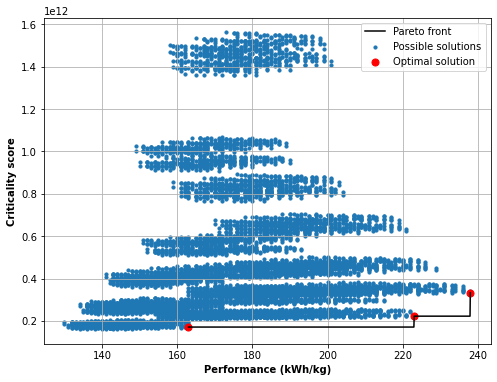

In [1214]:
from scipy.interpolate import make_interp_spline, BSpline

X = [round(x) for x in X]
Y = [round(x) for x in Y]
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(min(Y), max(Y), 1000)  

spl = make_interp_spline (Y, X, k=0)
power_smooth = spl(xnew)


fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(b_vector_nested_scaled[segment_choice].sum(1).round(0),performance_layer[range(len(segment_choice))].round(0), label='Possible solutions', s=2)
ax.scatter(performance_layer[range(len(segment_choice))].round(0),criticality_layer[range(len(segment_choice))].sum(1).round(0), label='Possible solutions', s=10)

ax.scatter(Y,X, c='r', label='Optimal solution',s=50)
plt.plot(xnew, power_smooth, c='black', label='Pareto front')

# ax.scatter(performance_layer[:-80],t1, s=2, label='Potential designs')
# ax.set_ylim([X[0], b_vector_nested_scaled[segment_choice].sum(1).round(0).max()])
# ax.set_xlim([performance_layer[range(len(segment_choice))].round(0).min(), Y[-1]])
# ax.set_xlim([Y[0], Y[-1]])
# ax.set_ylim([X[0], X[-1]])

# plt.plot (x_new,y_smooth)

# plt.plot(Y, X, c='black', )

ax.legend(loc='best')
plt.xlabel('Performance (kWh/kg)' ,fontweight='bold')
plt.ylabel('Criticality score',fontweight='bold')
plt.grid()
# fig.tight_layout()
# fig.savefig(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Written parts\Figures\results\MOO\pareto_gwp_perf.jpg', dpi=400, bbox_inches='tight')